In [1]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'


In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
from torchsummary import summary
import torch
use_cuda=torch.cuda.is_available()
import pytorch
from pytorch import dataset as ptd

import os
import datasets
import pytorch_models
import torch.optim as optim
dataset_name="fashion_mnist"
(x_train, y_train), (x_test, y_test), input_shape,num_classes = datasets.get_data(dataset_name)
dataset=ptd.ClassificationDataset(dataset_name,x_train,x_test,y_train,y_test,num_classes,input_shape)

print('x_train shape:', x_train.shape,x_train.dtype)
print('x_test shape:', x_test.shape,x_test.dtype)
print('y_train shape:', y_train.shape,y_train.dtype)
print('y_test shape:', y_test.shape,y_test.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


import numpy as np
print(np.unique(y_train.argmax(axis=1)))
print(y_train.min(),y_train.max())


Using TensorFlow backend.
/home/facundo/.python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


x_train shape: (60000, 28, 28, 1) uint8
x_test shape: (10000, 28, 28, 1) uint8
y_train shape: (60000, 10) float64
y_test shape: (10000, 10) float64
60000 train samples
10000 test samples
[0 1 2 3 4 5 6 7 8 9]
0.0 1.0


In [4]:
from pytorch import training

import pytorch_models

conv_filters={"mnist":32,"mnist_rot":32,"cifar10":64,"fashion_mnist":32}
fc_filters={"mnist":64,"mnist_rot":64,"cifar10":128,"fashion_mnist":64}
model = pytorch_models.SimpleConv(input_shape,num_classes,
                                 conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
#model= pytorch_models.FFNet(input_shape,num_classes)x
if use_cuda:
    model=model.cuda()
parameters=training.add_weight_decay(model.named_parameters(),1e-9)
optimizer = optim.Adam(parameters, lr=0.001)
print(model)

rotated_model= pytorch_models.SimpleConv(input_shape,num_classes,
                                       conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
if use_cuda:
    rotated_model= rotated_model.cuda()
rotated_parameters=training.add_weight_decay(rotated_model.named_parameters(),1e-9)
rotated_optimizer = optim.Adam(rotated_parameters, lr=0.001)

print(rotated_model)
#summary(model, input_size=[1,28,28])


SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): SequentialWithIntermediates(
    (0): Linear(in_features=6272, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(

Training model with unrotated dataset...


Epoch 1: 100% (batch 938/938)  ==stats==> loss:  0.441, accuracy:  0.841, Time:  0:00:11


Test => Loss: 0.3069, Accuracy: 88.37% (8837/10000)


Epoch 2: 100% (batch 938/938)  ==stats==> loss:  0.256, accuracy:  0.907, Time:  0:00:10


Test => Loss: 0.2485, Accuracy: 91.02% (9102/10000)


Epoch 3: 100% (batch 938/938)  ==stats==> loss:  0.211, accuracy:  0.923, Time:  0:00:10


Test => Loss: 0.2326, Accuracy: 91.75% (9175/10000)


Epoch 4: 100% (batch 938/938)  ==stats==> loss:  0.179, accuracy:  0.933, Time:  0:00:11


Test => Loss: 0.2392, Accuracy: 91.39% (9139/10000)


Epoch 5: 100% (batch 938/938)  ==stats==> loss:  0.153, accuracy:  0.943, Time:  0:00:09


Test => Loss: 0.2247, Accuracy: 92.21% (9221/10000)


Epoch 6: 100% (batch 938/938)  ==stats==> loss:  0.129, accuracy:  0.951, Time:  0:00:09


Test => Loss: 0.2267, Accuracy: 91.97% (9197/10000)


Epoch 7: 100% (batch 938/938)  ==stats==> loss:  0.107, accuracy:   0.96, Time:  0:00:09


Test => Loss: 0.2444, Accuracy: 92.52% (9252/10000)


Epoch 8: 100% (batch 938/938)  ==stats==> loss: 0.0927, accuracy:  0.965, Time:  0:00:09


Test => Loss: 0.2755, Accuracy: 92.17% (9217/10000)


Epoch 9: 100% (batch 938/938)  ==stats==> loss: 0.0762, accuracy:  0.971, Time:  0:00:09


Test => Loss: 0.2723, Accuracy: 92.09% (9209/10000)


Epoch 10: 100% (batch 938/938)  ==stats==> loss:  0.065, accuracy:  0.976, Time:  0:00:09


Test => Loss: 0.3144, Accuracy: 92.59% (9259/10000)


Epoch 11: 100% (batch 938/938)  ==stats==> loss: 0.0543, accuracy:   0.98, Time:  0:00:09


Test => Loss: 0.3279, Accuracy: 92.43% (9243/10000)


Epoch 12: 100% (batch 938/938)  ==stats==> loss: 0.0507, accuracy:  0.981, Time:  0:00:09


Test => Loss: 0.3716, Accuracy: 92.44% (9244/10000)


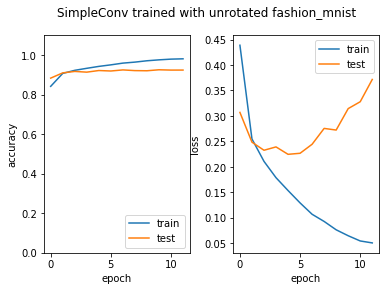

Skipping pretraining rotated model with unrotated dataset
Training rotated model with rotated dataset...


Epoch 1: 100% (batch 938/938)  ==stats==> loss:   1.07, accuracy:  0.598, Time:  0:00:08


Test => Loss: 0.7943, Accuracy: 70.09% (7009/10000)


Epoch 2: 100% (batch 938/938)  ==stats==> loss:  0.691, accuracy:  0.743, Time:  0:00:08


Test => Loss: 0.6712, Accuracy: 74.81% (7481/10000)


Epoch 3: 100% (batch 938/938)  ==stats==> loss:   0.58, accuracy:   0.79, Time:  0:00:08


Test => Loss: 0.5536, Accuracy: 80.16% (8016/10000)


Epoch 4: 100% (batch 938/938)  ==stats==> loss:  0.514, accuracy:  0.814, Time:  0:00:08


Test => Loss: 0.5135, Accuracy: 81.36% (8136/10000)


Epoch 5: 100% (batch 938/938)  ==stats==> loss:  0.475, accuracy:  0.828, Time:  0:00:08


Test => Loss: 0.4634, Accuracy: 83.36% (8336/10000)


Epoch 6: 100% (batch 938/938)  ==stats==> loss:  0.446, accuracy:  0.839, Time:  0:00:08


Test => Loss: 0.4586, Accuracy: 83.47% (8347/10000)


Epoch 7: 100% (batch 938/938)  ==stats==> loss:  0.424, accuracy:  0.846, Time:  0:00:08


Test => Loss: 0.4523, Accuracy: 83.70% (8370/10000)


Epoch 8: 100% (batch 938/938)  ==stats==> loss:   0.41, accuracy:  0.852, Time:  0:00:08


Test => Loss: 0.4273, Accuracy: 84.78% (8478/10000)


Epoch 9: 100% (batch 938/938)  ==stats==> loss:    0.4, accuracy:  0.855, Time:  0:00:08


Test => Loss: 0.4083, Accuracy: 85.38% (8538/10000)


Epoch 10: 100% (batch 938/938)  ==stats==> loss:  0.388, accuracy:  0.861, Time:  0:00:08


Test => Loss: 0.4011, Accuracy: 85.51% (8551/10000)


Epoch 11: 100% (batch 938/938)  ==stats==> loss:  0.378, accuracy:  0.863, Time:  0:00:08


Test => Loss: 0.4070, Accuracy: 85.31% (8531/10000)


Epoch 12: 100% (batch 938/938)  ==stats==> loss:  0.373, accuracy:  0.865, Time:  0:00:08


Test => Loss: 0.4114, Accuracy: 85.91% (8591/10000)


Epoch 13: 100% (batch 938/938)  ==stats==> loss:  0.362, accuracy:  0.869, Time:  0:00:08


Test => Loss: 0.4102, Accuracy: 85.10% (8510/10000)


Epoch 14: 100% (batch 938/938)  ==stats==> loss:  0.354, accuracy:  0.872, Time:  0:00:08


Test => Loss: 0.3896, Accuracy: 86.14% (8614/10000)


Epoch 15: 100% (batch 938/938)  ==stats==> loss:  0.352, accuracy:  0.872, Time:  0:00:08


Test => Loss: 0.3658, Accuracy: 87.08% (8708/10000)


Epoch 16: 100% (batch 938/938)  ==stats==> loss:  0.345, accuracy:  0.874, Time:  0:00:08


Test => Loss: 0.3741, Accuracy: 86.60% (8660/10000)


Epoch 17: 100% (batch 938/938)  ==stats==> loss:  0.341, accuracy:  0.876, Time:  0:00:08


Test => Loss: 0.3703, Accuracy: 87.08% (8708/10000)


Epoch 18: 100% (batch 938/938)  ==stats==> loss:   0.34, accuracy:  0.878, Time:  0:00:08


Test => Loss: 0.3734, Accuracy: 87.05% (8705/10000)


Epoch 19: 100% (batch 938/938)  ==stats==> loss:  0.336, accuracy:   0.88, Time:  0:00:08


Test => Loss: 0.3731, Accuracy: 86.91% (8691/10000)


Epoch 20: 100% (batch 938/938)  ==stats==> loss:  0.329, accuracy:  0.881, Time:  0:00:08


Test => Loss: 0.3564, Accuracy: 87.29% (8729/10000)


Epoch 21: 100% (batch 938/938)  ==stats==> loss:  0.325, accuracy:  0.883, Time:  0:00:08


Test => Loss: 0.3572, Accuracy: 87.43% (8743/10000)


Epoch 22: 100% (batch 938/938)  ==stats==> loss:  0.322, accuracy:  0.884, Time:  0:00:08


Test => Loss: 0.3716, Accuracy: 86.50% (8650/10000)


Epoch 23: 100% (batch 938/938)  ==stats==> loss:   0.32, accuracy:  0.884, Time:  0:00:08


Test => Loss: 0.3527, Accuracy: 87.99% (8799/10000)


Epoch 24: 100% (batch 938/938)  ==stats==> loss:  0.319, accuracy:  0.886, Time:  0:00:08


Test => Loss: 0.3583, Accuracy: 87.20% (8720/10000)


Epoch 25: 100% (batch 938/938)  ==stats==> loss:  0.313, accuracy:  0.886, Time:  0:00:08


Test => Loss: 0.3491, Accuracy: 87.64% (8764/10000)


Epoch 26: 100% (batch 938/938)  ==stats==> loss:  0.311, accuracy:  0.888, Time:  0:00:08


Test => Loss: 0.3556, Accuracy: 87.16% (8716/10000)


Epoch 27: 100% (batch 938/938)  ==stats==> loss:  0.308, accuracy:  0.887, Time:  0:00:08


Test => Loss: 0.3557, Accuracy: 87.10% (8710/10000)


Epoch 28: 100% (batch 938/938)  ==stats==> loss:  0.307, accuracy:   0.89, Time:  0:00:08


Test => Loss: 0.3473, Accuracy: 87.40% (8740/10000)


Epoch 29: 100% (batch 938/938)  ==stats==> loss:  0.308, accuracy:  0.888, Time:  0:00:08


Test => Loss: 0.3608, Accuracy: 87.56% (8756/10000)


Epoch 30: 100% (batch 938/938)  ==stats==> loss:  0.305, accuracy:  0.889, Time:  0:00:08


Test => Loss: 0.3566, Accuracy: 87.24% (8724/10000)


Epoch 31: 100% (batch 938/938)  ==stats==> loss:  0.298, accuracy:  0.893, Time:  0:00:08


Test => Loss: 0.3412, Accuracy: 87.54% (8754/10000)


Epoch 32: 100% (batch 938/938)  ==stats==> loss:  0.301, accuracy:   0.89, Time:  0:00:08


Test => Loss: 0.3407, Accuracy: 87.88% (8788/10000)


Epoch 33: 100% (batch 938/938)  ==stats==> loss:  0.302, accuracy:  0.891, Time:  0:00:08


Test => Loss: 0.3399, Accuracy: 88.09% (8809/10000)


Epoch 34: 100% (batch 938/938)  ==stats==> loss:  0.296, accuracy:  0.892, Time:  0:00:08


Test => Loss: 0.3303, Accuracy: 88.22% (8822/10000)


Epoch 35: 100% (batch 938/938)  ==stats==> loss:  0.294, accuracy:  0.893, Time:  0:00:08


Test => Loss: 0.3556, Accuracy: 87.64% (8764/10000)


Epoch 36: 100% (batch 938/938)  ==stats==> loss:  0.293, accuracy:  0.893, Time:  0:00:08


Test => Loss: 0.3433, Accuracy: 87.51% (8751/10000)


Epoch 37: 100% (batch 938/938)  ==stats==> loss:  0.293, accuracy:  0.895, Time:  0:00:08


Test => Loss: 0.3419, Accuracy: 87.87% (8787/10000)


Epoch 38: 100% (batch 938/938)  ==stats==> loss:   0.29, accuracy:  0.894, Time:  0:00:08


Test => Loss: 0.3363, Accuracy: 87.96% (8796/10000)


Epoch 39: 100% (batch 938/938)  ==stats==> loss:  0.287, accuracy:  0.895, Time:  0:00:08


Test => Loss: 0.3407, Accuracy: 88.00% (8800/10000)


Epoch 40: 100% (batch 938/938)  ==stats==> loss:  0.289, accuracy:  0.895, Time:  0:00:08


Test => Loss: 0.3341, Accuracy: 88.26% (8826/10000)


Epoch 41: 100% (batch 938/938)  ==stats==> loss:  0.287, accuracy:  0.895, Time:  0:00:08


Test => Loss: 0.3362, Accuracy: 87.96% (8796/10000)


Epoch 42: 100% (batch 938/938)  ==stats==> loss:  0.286, accuracy:  0.897, Time:  0:00:08


Test => Loss: 0.3326, Accuracy: 88.32% (8832/10000)


Epoch 43: 100% (batch 938/938)  ==stats==> loss:  0.281, accuracy:  0.898, Time:  0:00:08


Test => Loss: 0.3310, Accuracy: 88.42% (8842/10000)


Epoch 44: 100% (batch 938/938)  ==stats==> loss:  0.283, accuracy:  0.897, Time:  0:00:08


Test => Loss: 0.3327, Accuracy: 88.32% (8832/10000)


Epoch 45: 100% (batch 938/938)  ==stats==> loss:  0.285, accuracy:  0.896, Time:  0:00:08


Test => Loss: 0.3256, Accuracy: 88.48% (8848/10000)


Epoch 46: 100% (batch 938/938)  ==stats==> loss:  0.281, accuracy:  0.898, Time:  0:00:08


Test => Loss: 0.3336, Accuracy: 88.22% (8822/10000)


Epoch 47: 100% (batch 938/938)  ==stats==> loss:  0.282, accuracy:  0.898, Time:  0:00:08


Test => Loss: 0.3298, Accuracy: 88.55% (8855/10000)


Epoch 48: 100% (batch 938/938)  ==stats==> loss:  0.278, accuracy:  0.899, Time:  0:00:08


Test => Loss: 0.3245, Accuracy: 88.13% (8813/10000)


Epoch 49: 100% (batch 938/938)  ==stats==> loss:  0.278, accuracy:    0.9, Time:  0:00:08


Test => Loss: 0.3289, Accuracy: 88.26% (8826/10000)


Epoch 50: 100% (batch 938/938)  ==stats==> loss:   0.28, accuracy:  0.898, Time:  0:00:08


Test => Loss: 0.3204, Accuracy: 88.57% (8857/10000)


Epoch 51: 100% (batch 938/938)  ==stats==> loss:  0.278, accuracy:  0.898, Time:  0:00:08


Test => Loss: 0.3208, Accuracy: 88.35% (8835/10000)


Epoch 52: 100% (batch 938/938)  ==stats==> loss:  0.273, accuracy:    0.9, Time:  0:00:08


Test => Loss: 0.3167, Accuracy: 88.71% (8871/10000)


Epoch 53: 100% (batch 938/938)  ==stats==> loss:  0.273, accuracy:  0.901, Time:  0:00:08


Test => Loss: 0.3313, Accuracy: 88.46% (8846/10000)


Epoch 54: 100% (batch 938/938)  ==stats==> loss:  0.277, accuracy:    0.9, Time:  0:00:08


Test => Loss: 0.3277, Accuracy: 88.88% (8888/10000)


Epoch 55: 100% (batch 938/938)  ==stats==> loss:  0.275, accuracy:    0.9, Time:  0:00:08


Test => Loss: 0.3193, Accuracy: 88.82% (8882/10000)


Epoch 56: 100% (batch 938/938)  ==stats==> loss:  0.273, accuracy:    0.9, Time:  0:00:08


Test => Loss: 0.3368, Accuracy: 88.22% (8822/10000)


Epoch 57: 100% (batch 938/938)  ==stats==> loss:  0.274, accuracy:  0.902, Time:  0:00:08


Test => Loss: 0.3266, Accuracy: 88.49% (8849/10000)


Epoch 58: 100% (batch 938/938)  ==stats==> loss:  0.273, accuracy:    0.9, Time:  0:00:08


Test => Loss: 0.3162, Accuracy: 88.83% (8883/10000)


Epoch 59: 100% (batch 938/938)  ==stats==> loss:   0.27, accuracy:  0.901, Time:  0:00:08


Test => Loss: 0.3197, Accuracy: 88.95% (8895/10000)


Epoch 60: 100% (batch 938/938)  ==stats==> loss:  0.267, accuracy:  0.902, Time:  0:00:08


Test => Loss: 0.3280, Accuracy: 88.14% (8814/10000)


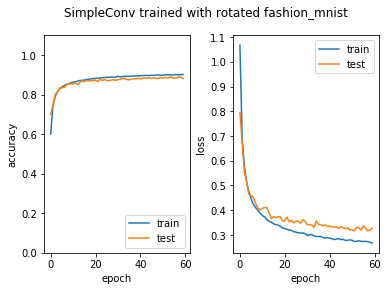

Testing both models on both datasets...


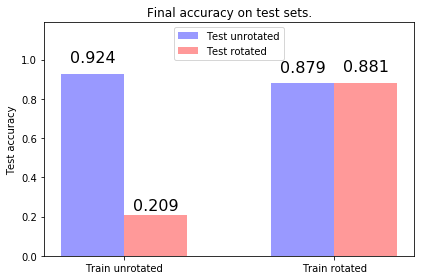

model_rotated_test_dataset score: loss=12.529874, accuracy=0.208800
model_rotated_train_dataset score: loss=12.647203, accuracy=0.212317
model_test_dataset score: loss=0.371611, accuracy=0.924400
model_train_dataset score: loss=0.031380, accuracy=0.988683
rotated_model_rotated_test_dataset score: loss=0.335951, accuracy=0.880800
rotated_model_rotated_train_dataset score: loss=0.276318, accuracy=0.898100
rotated_model_test_dataset score: loss=0.352206, accuracy=0.879300
rotated_model_train_dataset score: loss=0.293060, accuracy=0.893300


In [5]:
batch_size = 64

epochs={'cifar10':5,'mnist':2,'fashion_mnist':12,'cluttered_mnist':10,'lsa16':15,'mnist_rot':5,'pugeault':15}
from pytorch.experiment import rotation
rotated_epochs={'cifar10':100,'mnist':2,'fashion_mnist':60,'cluttered_mnist':30,'lsa16':100,'mnist_rot':5,'pugeault':40}

config=pytorch.experiment.rotation.TrainRotatedConfig(batch_size=batch_size,
                   epochs=epochs[dataset.name],rotated_epochs=rotated_epochs[dataset.name],
                   pre_rotated_epochs=0, optimizer=optimizer,rotated_optimizer=rotated_optimizer,
                  use_cuda=use_cuda)

scores=rotation.run(config,model,rotated_model,dataset,plot_accuracy=True,save_plots=False)
for k,v in scores.items():
    print('%s score: loss=%f, accuracy=%f' % (k,v[0],v[1]))


In [6]:
from pytorch.experiment import invariance_evaluation

n_rotations=16
#results=invariance_evaluation.run(model,dataset,config)
rotated_results,classes,rotations=invariance_evaluation.run(rotated_model,dataset,config,n_rotations)
results,classes,rotations=invariance_evaluation.run(model,dataset,config,n_rotations)




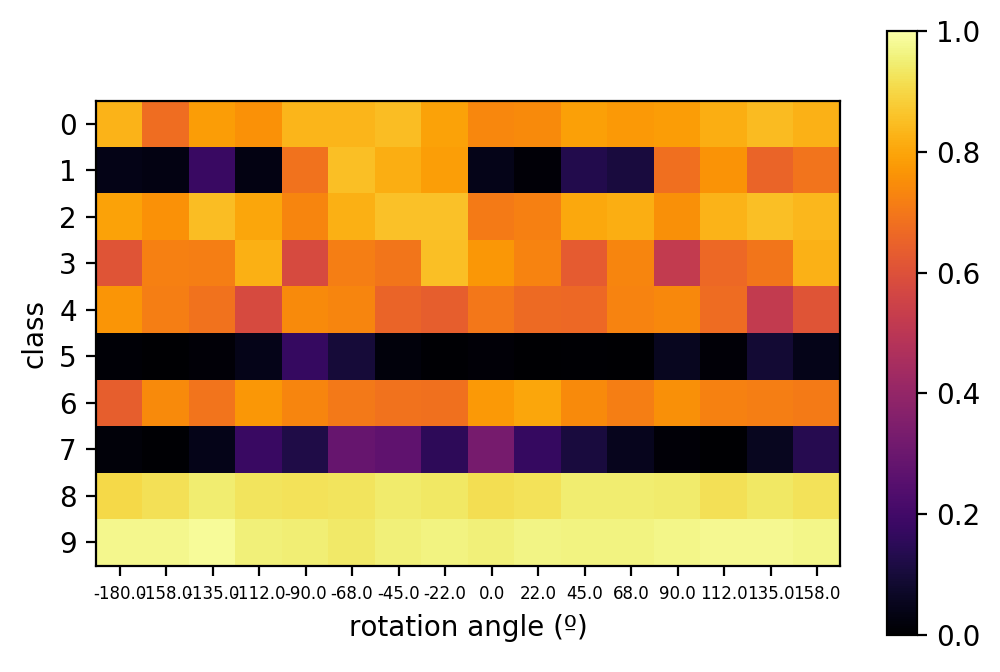

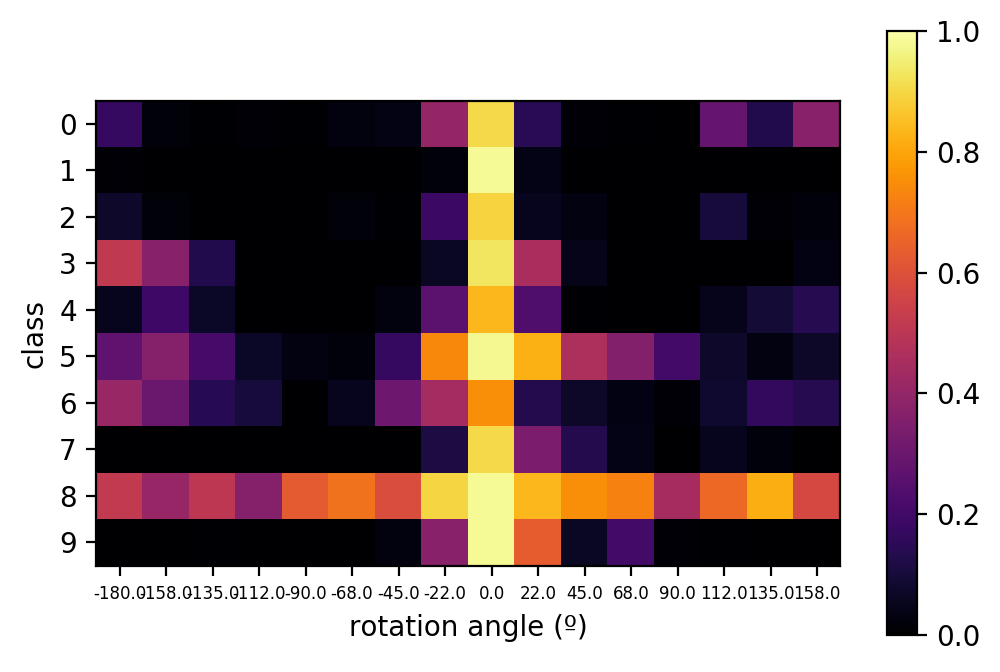

In [7]:
base_folder="plots/invariance_evaluation"
rotated_fig=invariance_evaluation.plot_results(rotated_results,classes,rotations)
name=f"{base_folder}/{dataset.name}_{model.name}_rotated.png"
rotated_fig.savefig(name)

fig=invariance_evaluation.plot_results(results,classes,rotations)
name=f"{base_folder}/{dataset.name}_{model.name}_unrotated.png"
fig.savefig(name)
